In [86]:
# ============================================
# 1) INSTALLS & IMPORTS
# ============================================
!pip install seaborn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib


In [87]:
# ============================================
# 2) LOAD SONAR DATASET
# ============================================

# Download sonar dataset if needed
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data -O sonar.csv

df = pd.read_csv("sonar.csv", header=None)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels: R → 0, M → 1
y = LabelEncoder().fit_transform(y)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [88]:
# ============================================
# 3) PYTORCH DATASET & DATALOADER
# ============================================

class SonarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SonarDataset(X_train, y_train)
test_ds  = SonarDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16)


In [89]:
# ============================================
# 4) MODEL (matches your saved checkpoint)
# ============================================

class SonarMLP(nn.Module):
    def __init__(self):
        super(SonarMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(60, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 32),   # extra layer you had in training
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.layers(x)

model = SonarMLP()


In [90]:
# ============================================
# 5) TRAINING SETUP
# ============================================

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accs = []
val_losses = []
val_accs = []


In [91]:
# ============================================
# 6) TRAINING LOOP
# ============================================

def evaluate(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)

            preds = (outputs >= 0.5).float()

            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            total_loss += loss.item()

    return total_loss / len(loader), correct / total


epochs = 350
for epoch in range(epochs):
    model.train()
    running_loss = 0
    running_correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        preds = (outputs >= 0.5).float()

        running_correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # track metrics
    train_loss = running_loss / len(train_loader)
    train_acc = running_correct / total
    val_loss, val_acc = evaluate(test_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


Epoch 1/350 | Train Loss: 0.6963 Acc: 0.4880 | Val Loss: 0.7030 Acc: 0.3810
Epoch 2/350 | Train Loss: 0.6905 Acc: 0.4880 | Val Loss: 0.6898 Acc: 0.3810
Epoch 3/350 | Train Loss: 0.6767 Acc: 0.5542 | Val Loss: 0.6705 Acc: 0.5714
Epoch 4/350 | Train Loss: 0.6551 Acc: 0.6747 | Val Loss: 0.6397 Acc: 0.7857
Epoch 5/350 | Train Loss: 0.6209 Acc: 0.7470 | Val Loss: 0.5941 Acc: 0.8095
Epoch 6/350 | Train Loss: 0.5814 Acc: 0.7530 | Val Loss: 0.5359 Acc: 0.8333
Epoch 7/350 | Train Loss: 0.4942 Acc: 0.8193 | Val Loss: 0.4560 Acc: 0.8571
Epoch 8/350 | Train Loss: 0.4178 Acc: 0.8614 | Val Loss: 0.3756 Acc: 0.8333
Epoch 9/350 | Train Loss: 0.3319 Acc: 0.8675 | Val Loss: 0.3288 Acc: 0.8333
Epoch 10/350 | Train Loss: 0.2870 Acc: 0.8976 | Val Loss: 0.3089 Acc: 0.8810
Epoch 11/350 | Train Loss: 0.2704 Acc: 0.9036 | Val Loss: 0.3231 Acc: 0.8810
Epoch 12/350 | Train Loss: 0.2082 Acc: 0.9217 | Val Loss: 0.2736 Acc: 0.8810
Epoch 13/350 | Train Loss: 0.1422 Acc: 0.9578 | Val Loss: 0.2769 Acc: 0.9048
Epoch 14

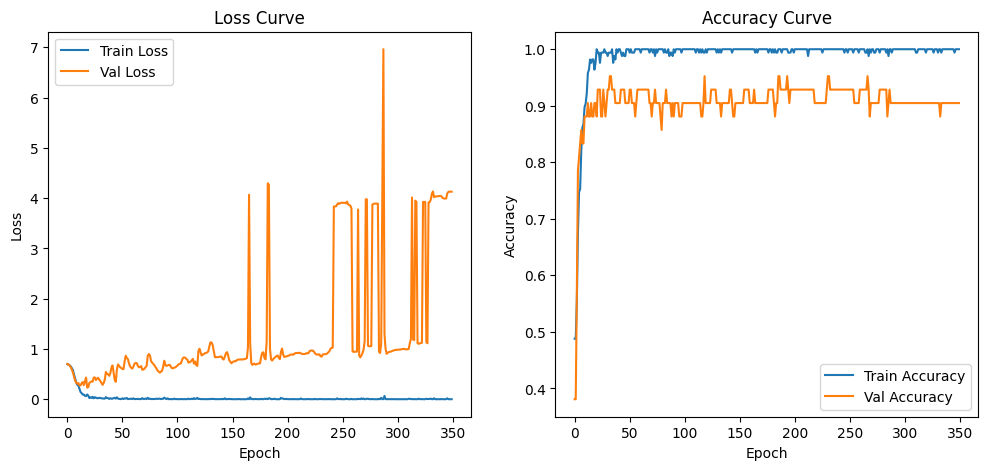

In [92]:
# ============================================
# 7) PLOT TRAINING CURVES
# ============================================

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


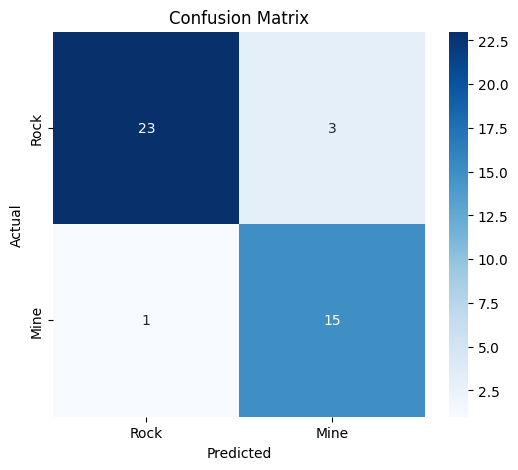

In [93]:
# ============================================
# 8) CONFUSION MATRIX
# ============================================

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rock', 'Mine'],
            yticklabels=['Rock', 'Mine'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


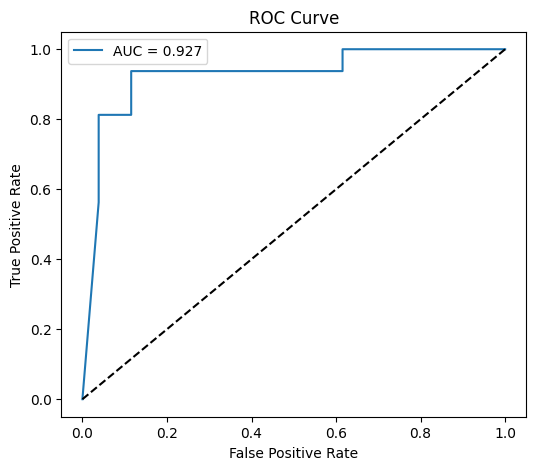

In [94]:
# ============================================
# 9) ROC CURVE
# ============================================

model.eval()
probs = []
labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        probs.extend(outputs.numpy())
        labels.extend(y_batch.numpy())

fpr, tpr, thresh = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [95]:
# ============================================
# 10) SAVE MODEL + SCALER
# ============================================

torch.save(model.state_dict(), "sonar_model.pth")
joblib.dump(scaler, "sonar_scaler.pkl")

print("Model and scaler saved!")


Model and scaler saved!


In [96]:
# ============================================
# 11) INFERENCE FUNCTION (tuple → Mine/Rock)
# ============================================

def load_model_for_inference():
    m = SonarMLP()
    m.load_state_dict(torch.load("sonar_model.pth", map_location='cpu'))
    m.eval()
    return m

inference_model = load_model_for_inference()
inference_scaler = joblib.load("sonar_scaler.pkl")


def predict_sonar(sample_tuple):
    # Convert tuple → numpy array
    sample = np.array(sample_tuple).reshape(1, -1)

    # Scale
    sample_scaled = inference_scaler.transform(sample)

    # To tensor
    sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)

    with torch.no_grad():
        output = inference_model(sample_tensor).item()

    return "Mine" if output >= 0.5 else "Rock"


In [97]:
# ============================================
# 12) TEST INFERENCE
# ============================================

example = tuple(X_test[2])  # try any data row
print("Prediction:", predict_sonar(example))


Prediction: Mine
